In [3]:
import numpy as np
import pandas as pd
import math
from numpy.linalg import inv
import matplotlib.pyplot as plt
from sympy import Symbol, symbols, Matrix, sin, cos, sqrt
from sympy import init_printing

In [ ]:
#Read Input File
measurements = pd.read_csv('data_ekf.txt',header=None, delim_whitespace = True, skiprows=1)

In [5]:
xs, ys, vx, vy, ax, ay, alp, phi, dphi, dt = symbols('x y vx vy ax ay alpha \psi \dot\psi T')

# desired state vector
number_of_states = 6
state = Matrix([xs,ys,vx,vy,phi,dphi])
state

Matrix([
[       x],
[       y],
[      vx],
[      vy],
[    \psi],
[\dot\psi]])

In [6]:
xt = Matrix([[xs + vx*dt],
            [ys + vy*dt],
            [vx],
            [vy],
            [phi + dphi*dt],
            [dphi]])
xt

Matrix([
[         T*vx + x],
[         T*vy + y],
[               vx],
[               vy],
[T*\dot\psi + \psi],
[         \dot\psi]])

In [7]:
F1 = xt.jacobian(state)
F1

Matrix([
[1, 0, T, 0, 0, 0],
[0, 1, 0, T, 0, 0],
[0, 0, 1, 0, 0, 0],
[0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 1, T],
[0, 0, 0, 0, 0, 1]])

In [8]:
# State space model: xt = F*(xt-1)+v

In [9]:
# Noise vector v:
#Considering acceleration and angular acceleration as noise the 
v = Matrix([[ax*(dt**2)/2],
           [ay*(dt**2)/2],
           [ax*dt],
           [ay*dt],
           [alp*(dt**2)/2],
           [alp*dt]])
v

Matrix([
[   T**2*ax/2],
[   T**2*ay/2],
[        T*ax],
[        T*ay],
[T**2*alpha/2],
[     T*alpha]])

In [10]:
# Calculating Q
# Q = E(v*vt) = G*Qv*Gt  
#accelration noise considered as gaussian distribution with mean = 0 and some variance
G = Matrix([[dt**2/2, 0, 0],
            [0, dt**2/2, 0],
            [dt, 0, 0],
            [0, dt, 0],
            [0, 0, dt**2/2],
            [0, 0, dt]])

a = Matrix([[ax],
            [ay],
            [alp]])
sig_ax, sig_ay, sig_alp = symbols('sigma_ax sigma_ay sigma_alpha')

Qv = Matrix([[sig_ax**2, 0, 0],
              [0, sig_ay**2, 0],
             [0, 0, sig_alp**2]])
Q1 = G*Qv*G.T
Q1

Matrix([
[T**4*sigma_ax**2/4,                  0, T**3*sigma_ax**2/2,                  0,                     0,                     0],
[                 0, T**4*sigma_ay**2/4,                  0, T**3*sigma_ay**2/2,                     0,                     0],
[T**3*sigma_ax**2/2,                  0,   T**2*sigma_ax**2,                  0,                     0,                     0],
[                 0, T**3*sigma_ay**2/2,                  0,   T**2*sigma_ay**2,                     0,                     0],
[                 0,                  0,                  0,                  0, T**4*sigma_alpha**2/4, T**3*sigma_alpha**2/2],
[                 0,                  0,                  0,                  0, T**3*sigma_alpha**2/2,   T**2*sigma_alpha**2]])

In [11]:
# Radar measurement model (r, rdot, phi)
radar = Matrix([[sqrt(xs**2+ys**2)],
                [(xs*vx +ys*vy)/(sqrt(xs**2+ys**2))],
                [phi]])
radar

Matrix([
[              sqrt(x**2 + y**2)],
[(vx*x + vy*y)/sqrt(x**2 + y**2)],
[                           \psi]])

In [12]:
#To linearize calculating jacobian
H_radar = radar.jacobian(state)

In [13]:
# Radar Noise covariance matrix 

R_radar = np.array([
        [0.09, 0, 0],
        [0, 0.09, 0],
        [0, 0, 0.09]
        ])
# Radar Measurement Matrix
z_radar = np.zeros([3, 1])


In [14]:
# Lidar measurement model (x, y)

H_lidar = np.array([
        [1.0, 0, 0, 0, 0, 0],
        [0, 1.0, 0, 0, 0, 0]
        ])

# LIDAR Noise covariance matrix 
R_lidar = np.array([
        [0.0225, 0],
        [0, 0.0225]
        ])

# LIDAR Measurement Matrix
z_lidar = np.zeros([2, 1])

In [15]:
def EKF_predict():
  # Predict Step
  global x, P, Q
  # Estimate of x
  x = np.matmul(F, x)
  Ft = np.transpose(F)
  # Project the error covariance ahead
  P = np.add(np.matmul(F, np.matmul(P, Ft)), Q)

In [16]:

def EKF_update(z, sensor):
  global x, P  
  PI = math.pi
  # Measurement Update (Correction) & Kalman Gain
  if sensor == 'R':
    H = H_radar.subs([(xs,x[0][0]), (ys,x[1][0]), (vx,x[2][0]), (vy,x[3][0])])
    zpred = np.add(np.matmul(H, x),w_radar)
  else:
    H = H_lidar
    zpred = np.add(np.matmul(H, x),w_lidar)
  
  Ht = np.transpose(H)
  S = np.add(np.matmul(H, np.matmul(P, Ht)), R)
  PHt = np.matmul(P, Ht)
  S = np.array(S, dtype=np.float)
  Si = inv(S)
  K = np.matmul(PHt, Si)
  Y = np.subtract(z, zpred )
  
  # To normalize phi between pi and -pi
  if sensor == 'R':
    while(Y[2][0] > PI):
      Y[2][0] = Y[2][0] -2*PI
    while(Y[2][0] < -PI):
      Y[2][0] = Y[2][0] + 2*PI

  #Update the estimate
  x = np.add(x, np.matmul(K,Y))

  #Update the error covariance
  P = np.matmul(np.subtract(I,np.matmul(K,H)),P)



In [17]:


#Manualy copy initial readings from first row of input file.
prv_time = 1477010443000000/1000000.0
global x
PI = math.pi
x = np.array([
        [0.312242], 
        [0.5803398],
        [0],
        [0],
        [0],
        [0]
        ])

#Initialize matrices P matrix
P = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1000, 0, 0, 0],
        [0, 0, 0, 1000, 0, 0],
        [0, 0, 0, 0, 1000, 0],
        [0, 0, 0, 0, 0, 1000]])

I = np.identity(6)
ground_truth = np.zeros([6, 1])

# Noise variances
noise_ax = 3
noise_ay = 3
noise_alpha = 6

#Considering Sensor Noise as:
w_radar = np.array([
        [0.05], 
        [0.05],
        [0.9],
        ])
w_lidar = np.array([
        [0.001], 
        [0.001]])

x_Estimate = []
y_Estimate = []
x_groundtruth = []
y_groundtruth = []

#Looping over all the measurement values in data_ekf.txt file
for i in range (len(measurements)):
  new_measurement = measurements.iloc[i, :].values

  if new_measurement[0] == 'L':
    #Calculate Timestamp and its power variables
    cur_time = new_measurement[3]/1000000.0
  if new_measurement[0] == 'R':
    cur_time = new_measurement[4]/1000000.0

  Dt = cur_time - prv_time
  prv_time = cur_time
  Q = Q1.subs([(dt,Dt), (sig_ax,noise_ax), (sig_ay,noise_ay), (sig_alp,noise_alpha)])
  F = F1.subs(dt,Dt)

  # If LIDAR Data 
  if new_measurement[0] == 'L':
    #Updating sensor readings
    z_lidar[0][0] = new_measurement[1]
    z_lidar[1][0] = new_measurement[2]

    #Collecting ground truths
    ground_truth[0] = new_measurement[4]
    ground_truth[1] = new_measurement[5]
    ground_truth[2] = new_measurement[6]
    ground_truth[3] = new_measurement[7]
    ground_truth[4] = new_measurement[8]
    ground_truth[5] = new_measurement[9]

    R = R_lidar

    #Prediction step
    EKF_predict()
    #Updation step
    EKF_update(z_lidar, new_measurement[0])

    x_Estimate.insert(i, x[0][0])
    y_Estimate.insert(i, x[1][0])
    x_groundtruth.insert(i, ground_truth[0][0])
    y_groundtruth.insert(i, ground_truth[1][0])

    print("#", i, ":", cur_time)
    print("--------------------------------------------------------------------------------")
    print('{:15s} | {:8.3f} | {:8.3f} |'.format("LIDAR:", z_lidar[0][0], z_lidar[1][0])) 
    print('{:10s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("Estimate      :", x[0][0], x[1][0], x[2][0], x[3][0], x[4][0], x[5][0] ))
    print('{:10s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("Ground Truth  :", ground_truth[0][0], ground_truth[1][0], ground_truth[2][0], ground_truth[3][0], ground_truth[4][0], ground_truth[5][0]))
   
    print('')
  #If RADAR data
  if new_measurement[0] == 'R':

    #Updating sensor readings
    z_radar[0][0] = new_measurement[1]#r
    z_radar[1][0] = new_measurement[3]#rdot
    z_radar[2][0] = new_measurement[2]#phi

    #Collecting ground truths
    ground_truth[0] = new_measurement[5]
    ground_truth[1] = new_measurement[6]
    ground_truth[2] = new_measurement[7]
    ground_truth[3] = new_measurement[8]
    ground_truth[4] = new_measurement[9]
    ground_truth[5] = new_measurement[10]

    R = R_radar

    EKF_predict()
    EKF_update(z_radar, new_measurement[0])
    #print(x)
    x_Estimate.insert(i, x[0][0])
    y_Estimate.insert(i, x[1][0])
    x_groundtruth.insert(i, ground_truth[0][0])
    y_groundtruth.insert(i, ground_truth[1][0])
 
   
    print("#", i, ":", cur_time)
    print("--------------------------------------------------------------------------------")
    print('{:15s} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("RADAR:", z_radar[0][0], z_radar[1][0], z_radar[2][0])) 
    print('{:10s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("Estimate      :", x[0][0], x[1][0], x[2][0], x[3][0], x[4][0], x[5][0] ))
    print('{:10s} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} | {:8.3f} |'.format("Ground Truth  :", ground_truth[0][0], ground_truth[1][0], ground_truth[2][0], ground_truth[3][0], ground_truth[4][0], ground_truth[5][0]))
    
    print('')





  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


# 0 : 1477010443.05
--------------------------------------------------------------------------------
RADAR:          |    1.015 |    4.893 |    0.554 |
Estimate      : |    0.455 |    0.845 |    2.294 |    4.265 |   -0.346 |   -0.017 |
Ground Truth  : |    0.860 |    0.600 |    5.200 |    0.002 |    0.000 |    0.014 |

# 1 : 1477010443.1
--------------------------------------------------------------------------------
LIDAR:          |    1.174 |    0.481 |
Estimate      : |    1.194 |    0.523 |    8.724 |    0.792 |   -0.347 |   -0.017 |
Ground Truth  : |    1.120 |    0.600 |    5.199 |    0.005 |    0.001 |    0.021 |

# 2 : 1477010443.15
--------------------------------------------------------------------------------
RADAR:          |    1.048 |    4.511 |    0.389 |
Estimate      : |    1.282 |    0.675 |    3.806 |    3.425 |   -0.509 |   -1.622 |
Ground Truth  : |    1.380 |    0.601 |    5.199 |    0.011 |    0.002 |    0.028 |

# 3 : 1477010443.2
------------------------------

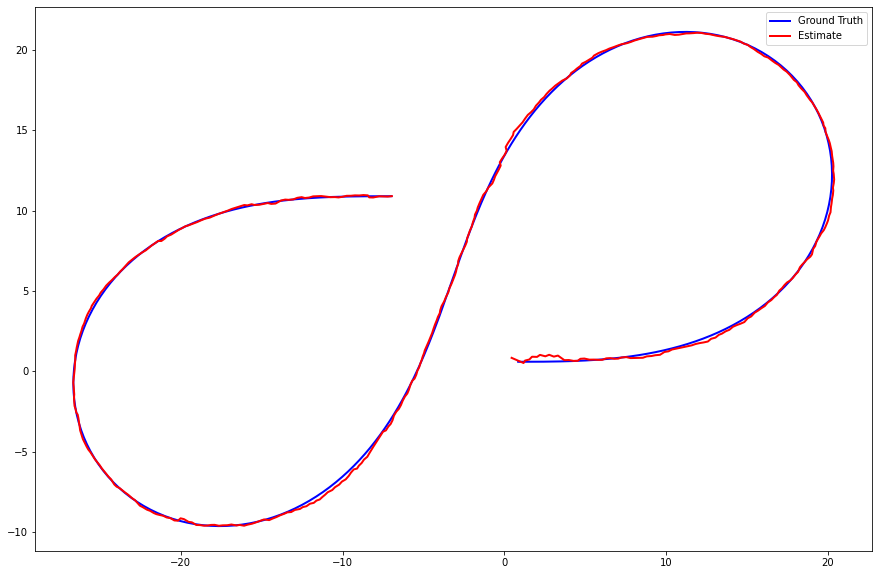

In [18]:
plt.rcParams["figure.figsize"] = (15,10)

# Plot of (x, y) predicted and ground truth
plt.plot(x_groundtruth, y_groundtruth, color = 'blue', linewidth=2, label = 'Ground Truth')
plt.plot(x_Estimate, y_Estimate,color = 'red', linewidth=2, label = 'Estimate')
plt.legend()
plt.show()
